# Weight Decay

$$
\mathbf{w^*} = \arg\min \ell(\mathbf{w}, b)+\frac{\lambda}{2}\|\mathbf{w}\|^{2}
$$

- calculate the gradient

$$
\frac{\partial}{\partial \mathbf{w}}\left(\ell(\mathbf{w}, b)+\frac{\lambda}{2}\|\mathbf{w}\|^{2}\right)=\frac{\partial \ell(\mathbf{w}, b)}{\partial \mathbf{w}}+\lambda \mathbf{w}
$$

- update parameter `t`

$$
\mathbf{w}_{t+1}=(1-\eta \lambda) \mathbf{w}_{t}-\eta \frac{\partial \ell\left(\mathbf{w}_{t}, b_{t}\right)}{\partial \mathbf{w}_{t}}
$$

- normally $\eta\lambda < 1$, which is called weight decay
- to control the complexity of model


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

$$
y=0.05+\sum_{i=1}^{d} 0.01 x_{i}+\epsilon \text { where } \epsilon \sim \mathcal{N}\left(0,0.01^{2}\right)
$$

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [3]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [4]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [5]:
def train(lambd, num_epochs=100, lr=0.003):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
#     num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # The L2 norm penalty term has been added, and broadcasting
            # makes `l2_penalty(w)` a vector whose length is `batch_size`
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', torch.norm(w).item())

L2 norm of w: 14.211816787719727


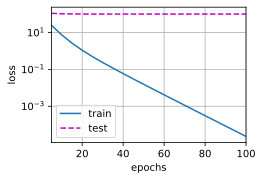

In [6]:
train(lambd=0)

L2 norm of w: 0.03353245183825493


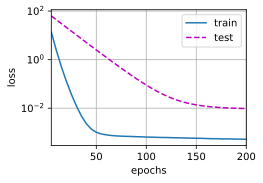

In [8]:
train(lambd=3, num_epochs=200, lr=0.003)

In [9]:
def train_concise(wd, num_epochs=100, lr=0.003):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
#     num_epochs, lr = 100, 0.003
    # The bias parameter has not decayed
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('L2 norm of w:', net[0].weight.norm().item())

L2 norm of w: 13.190892219543457


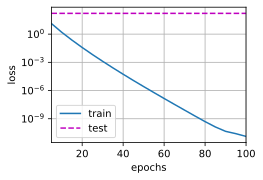

In [10]:
train_concise(0)

L2 norm of w: 0.07729178667068481


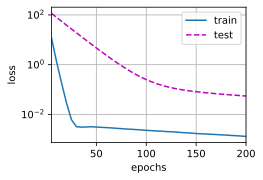

In [11]:
train_concise(3, num_epochs=200, lr=0.003)